## Usefuls sources of informations:

* https://github.com/hbjornoy/deep-learning/blob/master/project2/helpers.py
* https://github.com/Ertugrulmert/EPFL-Deep-Learning-Projects/blob/master/Project_2/framework.py
* https://github.com/marieanselmet/DeepLearningEPFL_projects/tree/main/DL_framework_from_scratch

La grande différence est que tout le monde définit module avec un argument, et non une liste * -> à voir si on doit changer pour faire comme les années précédentes ou s'il y a qqc de plus pratique

## TODO

* Pour les modules retournant une empty list sur param, enlever la fonction param (ça sert à rien de l'override)

In [1]:
import torch
import math
import time
import datetime
import random

from torch import Tensor
torch.set_grad_enabled(False)

In [2]:
# The father of all Modules
class Module(object):
    def forward(self, *input):
        raise NotImplementedError
        
    def backward(self, *gradwrtoutput):
        raise NotImplementedError
        
    def param(self):
        return []

## Activation

À part ReLU et Tanh c'est pas précisé dans l'énoncé - là c'est juste pour le flex

In [3]:
class ReLU(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input):
        self.t = input
        return input.clamp(0)

    def backward(self, gradwrtoutput):
        input = self.t
        sign = input.sign().clamp(0)
        return sign * gradwrtoutput
        
    def param(self):
        return []

In [4]:
class Tanh(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input):
        self.t = input
        
        out = []
        for x in input :
            e = math.exp(-2 * x)
            val = (1 - e) / (1 + e)
            out.append(val)
        return torch.FloatTensor(out)

    def backward(self, gradwrtoutput):
        z = self.t
        e = torch.exp(-2 * z)
        d_tanh = 4 * e / (1 + e)**2
        return d_tanh * gradwrtoutput
        
    def param(self):
        return []

In [5]:
class Sigmoid(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input):
        self.t = input
        return input.mul(-1).exp().add(1).pow(-1)

    def backward(self, gradwrtoutput):
        sig = self.t.mul(-1).exp().add(1).pow(-1)
        return sig.mul(-1).add(1).mul(sig)
        
    def param(self):
        return []

In [6]:
r = ReLU()
th = Tanh()
s = Sigmoid()

t = torch.FloatTensor([-10, 0, 1, 3, 10])

print(r.forward(t))
print(r.backward(t))
print(th.forward(t))
print(th.backward(t))
print(s.forward(t))
print(s.backward(t))

tensor([ 0.,  0.,  1.,  3., 10.])
tensor([-0.,  0.,  1.,  3., 10.])
tensor([-1.0000,  0.0000,  0.7616,  0.9951,  1.0000])
tensor([-8.2446e-08,  0.0000e+00,  4.1997e-01,  2.9598e-02,  8.2446e-08])
tensor([4.5398e-05, 5.0000e-01, 7.3106e-01, 9.5257e-01, 9.9995e-01])
tensor([4.5396e-05, 2.5000e-01, 1.9661e-01, 4.5177e-02, 4.5417e-05])


In [7]:
class LeakyReLU(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, *input):
        raise NotImplementedError

    def backward(self, *gradwrtoutput):
        raise NotImplementedError
        
    def param(self):
        return []

In [8]:
class ELU(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, *input):
        raise NotImplementedError

    def backward(self, *gradwrtoutput):
        raise NotImplementedError
        
    def param(self):
        return []

In [9]:
class CReLU(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, *input):
        raise NotImplementedError

    def backward(self, *gradwrtoutput):
        raise NotImplementedError
        
    def param(self):
        return []

## Linear

In [10]:
class Linear(Module):
    def __init__(self, input_size, output_size, mean=0, std=1):
        super().__init__()
        self.W = torch.empty(output_size, input_size).normal_(mean, std)
        self.b = torch.empty(output_size).normal_(mean, std)
        self.dW = torch.zeros(output_size, input_size)
        self.db = torch.zeros(output_size)
    def forward(self, input):
        self.t = input
        return self.W.mv(input).add(self.b)

    def backward(self, gradwrtoutput):
        self.dW.add_(gradwrtoutput.view(1, -1).t().mm(self.t.view(1, -1)))
        self.db.add_(gradwrtoutput)
        return self.W.t().mv(gradwrtoutput)
        
        
    def param(self):
        return [(self.W, self.dW), (self.b, self.db)]

In [11]:
l = Linear(10, 10)
t = torch.empty(10).fill_(1)
l.forward(t)
l.backward(t)

tensor([ 6.5623, -0.4682, -1.1182, -4.3830,  4.4465, -1.2512, -1.7061,  1.8404,
         3.3364,  2.2516])

In [12]:
class Dropout(Module):
    def __init__(self, p = 0.5):
        super().__init__()
        self.p = p
        
    def forward(self, input):
        for i in range(input.shape[0]):
            if random.random() < self.p : 
                input[i] = 0 
        return input
    
    def backward(self, gradwrtoutput):
        return gradwrtoutput
        
        
    def param(self):
        return []

In [13]:
l = Dropout(0.5)
t = torch.empty(10).fill_(1)
l.forward(t)

tensor([1., 1., 1., 1., 0., 1., 0., 1., 0., 0.])

## Sequential

Lui en input il prend une liste de modules et son fwd c'est de feed le fwd de chaque layer dans l'autre

In [14]:
class Sequential(Module):
    def __init__(self, module_list):
        super().__init__()
        self.modules = module_list
        
    def forward(self, input):
        x = input
        for module in self.modules :
            x = module.forward(x)
        return x 

    def backward(self, gradwrtoutput):
        x = gradwrtoutput
        for module in self.modules :
            x = module.backward(x)
        return x
        
    def param(self):
        return []

In [15]:
s = Sequential([Linear(10,10), Linear(10,5), Linear(5,2)])


## Loss

Seule lossMSE est demandé

In [16]:
class LossMSE(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        return (pred - target.float()).pow(2).mean()
    
    # J'ai pas mis les arguments dans backward car je pars du principe que la MSE est la dernière fonction utilisée
    def backward(self):
        return 2 * (self.pred - self.target)
    
    def param(self):
        return []

In [17]:
class LossMAE(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        return (pred - target.float()).abs().mean()

    def backward(self):
        error = self.pred - self.target
        return error.sign()
        
    def param(self):
        return []

In [18]:
# Binary cross entropy loss
# Note: We need to use sigmoid function before using BCE otherwise it makes no sense
class LossBCE(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        print(target * pred.log())
        return ((target * pred.log()) + ((1 - target) * (1 - pred).log())).mean()

    def backward(self):
        return ((-target/pred) + ((1 - target)/(1 - pred))).mean()
        
    def param(self):
        return []

In [19]:
# Test

target = torch.FloatTensor([1, 1, 1])
pred = torch.FloatTensor([0, 1, 3])
lossMSE = LossMSE()
print(lossMSE.forward(pred, target))
print(lossMSE.backward())

tensor(1.6667)
tensor([-2.,  0.,  4.])


In [20]:
# Test

target = torch.FloatTensor([1, 1, 1])
pred = torch.FloatTensor([0, 1, 3])
lossMAE = LossMAE()
print(lossMAE.forward(pred, target))
print(lossMAE.backward())

tensor(1.)
tensor([-1.,  0.,  1.])


In [21]:
# Test

target = torch.FloatTensor([0, 0, 1, 1])
pred = torch.FloatTensor([0.3, 0.1, 0.6, 0.1])
lossBCE = LossBCE()
print(lossBCE.forward(pred, target))
print(lossBCE.backward())

tensor([-0.0000, -0.0000, -0.5108, -2.3026])
tensor(-0.8189)
tensor(-2.2817)


## Optimizer

Pas demandé mais fancy

In [22]:
class SGD():
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr
    
    def step(self):
        for module in self.params:
            for tup in module:
                param, grad = tup
                if (param is not None) and (grad is not None):
                    param.add_(grad, alpha=self.lr)
    
    def zero_grad(self):
        for module in self.params:
            for tup in module:
                param, grad = tup
                if (param is not None) and (grad is not None):
                    grad.zero_()
                    
    def show(self):
        # To remove, for debugging
        for i in self.params:
            print(i)

In [202]:
# Mazel Tov si on y arrive
class Adam():
    def __init__(self, params, lr, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8):
        self.params = params
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        
        # Adam inner values 
        self.t = 0
        self.adam_values = torch.zeros_like(params)
    
    def step(self):
        self.t += 1 
        for idx_module, module in enumerate(self.params):
            for idx_tup, tup in enumerate(module):
                param, grad = tup
                if (param is not None) and (grad is not None):
                    #Update Vd and Sd, for each tuple we keep vd and sd 
                    vd, sd = self.adam_values[idx_module, idx_tup]
                    
                    vd.mul_(self.beta_1).add_(grad.mul(1 - self.beta_1))
                    sd.mul_(self.beta_2).add_(grad.pow(2).mul(1 - self.beta_2))
                    
                    # Compute corrected Values
                    vd_corr = vd.mul(torch.tensor([[self.beta_1]]).pow(self.t).mul(-1).add(1).pow(-1)) 
                    sd_corr = sd.mul(torch.tensor([[self.beta_2]]).pow(self.t).mul(-1).add(1).pow(-1)) 
                    
                    # Update the parameter 
                    param.add_(sd_corr.sqrt().add(self.epsilon).pow(-1).mul(vd_corr)[0][0], alpha=self.lr)
        
    def zero_grad(self):
        for module in self.params:
            for tup in module:
                param, grad = tup
                if (param is not None) and (grad is not None):
                    grad.zero_()
                    
    def show(self):
        # To remove, for debugging
        print(self.t)
        print("PARAMS : ")
        for i in self.params:
            print(i)
        print(("ADAM [Vd, Sd] : "))
        for i in self.adam_values:
            print(i)

In [203]:
params = torch.FloatTensor([[(10, 5), (10, -20)], [(0, 10), (0, -10)]])
adam = Adam(params , 0.1)
adam.show()
adam.step()
adam.zero_grad()
adam.show()


0
PARAMS : 
tensor([[ 10.,   5.],
        [ 10., -20.]])
tensor([[  0.,  10.],
        [  0., -10.]])
ADAM [Vd, Sd] : 
tensor([[0., 0.],
        [0., 0.]])
tensor([[0., 0.],
        [0., 0.]])
1
PARAMS : 
tensor([[10.1000,  0.0000],
        [ 9.9000,  0.0000]])
tensor([[ 0.1000,  0.0000],
        [-0.1000,  0.0000]])
ADAM [Vd, Sd] : 
tensor([[ 0.5000,  0.0250],
        [-2.0000,  0.4000]])
tensor([[ 1.0000,  0.1000],
        [-1.0000,  0.1000]])


In [178]:
params = torch.FloatTensor([[(10, 5), (10, -20)], [(0, 10), (0, -10)]])
sgd = SGD(params , 0.1)
sgd.step()
sgd.show()
sgd.zero_grad()
sgd.show()

tensor([[ 10.5000,   5.0000],
        [  8.0000, -20.0000]])
tensor([[  1.,  10.],
        [ -1., -10.]])
tensor([[10.5000,  0.0000],
        [ 8.0000,  0.0000]])
tensor([[ 1.,  0.],
        [-1.,  0.]])


## Data generation

In [25]:
def generate_disc_dataset(nb, seed=0):
    torch.manual_seed(seed)
    input = torch.empty(nb, 2).uniform_(0, 1)
    
    distance = torch.norm((input - torch.Tensor([[0.5, 0.5]])), 2, 1, True)
    target = distance.mul(math.sqrt(2*math.pi)).sub(1).sign().sub(1).div(-2).long()  
    return input, target

In [26]:
# Pas sûr de l'interêt du one hot encoder vu l'énoncé mais je peux me tromper 
def one_hot_encoder(target):
    return torch.empty(target.size(0), 2).zero_().scatter_(1, target.view(-1, 1), 1)

In [27]:
def split_dataset(input, target, train_perc):
    train_part = math.floor(target.size()[0] * train_perc)
    test_part = target.size()[0] - train_part
    
    train_input = input.narrow(0, 0, train_part)
    test_input = input.narrow(0, train_part, test_part)
    
    train_target = target.narrow(0, 0, train_part)
    test_target = target.narrow(0, train_part, test_part)
    
    return train_input, train_target, test_input, test_target

In [28]:
def normalize_data(train, test):
    mean, std = train.mean(), train.std()
    train = (train - mean) / std
    test = (test - mean) / std
    return train, test

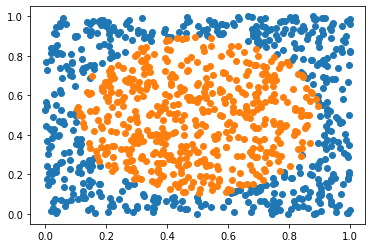

In [82]:
import matplotlib.pyplot as plt 

input, target = generate_disc_dataset(1000)

zeros = input[(target == 0).nonzero()[:,0]]
ones = input[target.nonzero()[:,0]]

plt.scatter(zeros[:,0], zeros[:,1])
plt.scatter(ones[:,0], ones[:,1])
plt.show()

In [ ]:
one_hot_encoder(target)

## Train / Test

In [ ]:
def train(model, train_input, train_target, learning_rate=0.01, nb_epochs=25):
    sgd = SGD(model.params(), lr)
    
    
    for epoch in range(nb_epochs):
            for x in range(train_input.size()[0])
            sgd.zero_grad()
            
            for layer in model 
            
    return model
    
def test(model, test_input, test_label):
    print(667)

## Data creation and code 

Note: j'ai pas compris si on doit utiliser 1000 datasets pour le train + 1000 dataset pour le test, pour le moment j'ai fait 1000 pour les 2 et je split ensuite, à voir comment on veut faire 

Note: Si on veut faire un truc fancy et visualiser notre data, il faudrait faire l'opération "inverse" du normalize data sur le dataset 

TODO: lr hypertuning w/ validation ? 

In [ ]:
input, target = generate_disc_dataset(1000)
train_input, train_target, test_input, test_target = split_dataset(input, target, 0.8)
train_input, test_input = normalize_data(train_input, test_input)

# Pas sûr si on doit faire une activation fonction à la fin
model = Sequential([Linear(2, 25), ReLU(), Linear(25, 25), ReLU(), Linear(25, 25), ReLU(), Linear(25, 1)])
model = train(model, train_input, train_label)
test(model, test_input, test_label)